In [1]:
import pandas as pd
import datetime
import numpy as np
import matplotlib as plt
import stock_utils as su

from sklearn.externals import joblib

from sklearn.linear_model import Ridge, LinearRegression, SGDRegressor, ElasticNet, Lasso
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split

%matplotlib inline

## Choose a ticker symbol and generate a dataset with selected new features for it

In [2]:
#create a dataset for AAPL
rs = 42 # random state
tickers = ['AAPL', 'XOM', 'JNJ']
symbol = tickers[0]
window = 5
look_ahead = 1
start_date = datetime.datetime(2010, 1, 1)
end_date = datetime.datetime(2016, 12, 31)

In [3]:
dataset = su.preprocess_data(symbol, window, look_ahead, start_date, end_date)

data = dataset.drop(labels=['Future Price'], axis=1)
target = dataset['Future Price']

dataset.head()

,Adj. Open,Adj. High,Adj. Low,Adj. Close,Daily return,Rolling mean 5,Lower Bollinger band 5,Upper Bollinger band 5,Cummulative return 5,Future Price
2010-01-06,27.550818,27.660055,27.084312,27.112585,-0.015906,27.434641,27.072225,27.797058,-0.014205,27.062465
2010-01-07,27.212826,27.244955,26.865839,27.062465,-0.001849,27.346481,26.870781,27.822180,-0.016027,27.242385
2010-01-08,27.026481,27.244955,26.867124,27.242385,0.006648,27.294304,26.848286,27.740322,-0.009486,27.242385
2010-01-09,27.026481,27.244955,26.867124,27.242385,0.000000,27.242127,26.862194,27.622061,-0.009486,27.242385
2010-01-10,27.026481,27.244955,26.867124,27.242385,0.000000,27.180441,27.007138,27.353743,-0.011195,27.002063


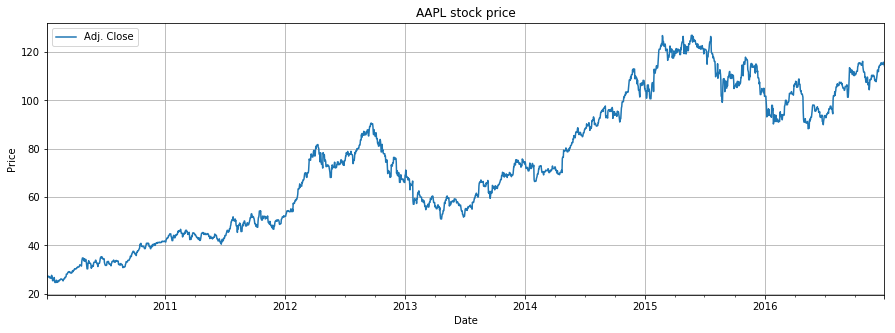

In [4]:
data_frame = data[['Adj. Close']]
ax = data_frame.plot(figsize=(15,5), grid=True, title='{0} stock price'.format(symbol))

ax.set_xlabel('Date')
ax.set_ylabel('Price')
ax.legend(loc='upper left')

## Find hyperparameters for model

In [5]:
lasso = Lasso(random_state=rs)
lasso_params = {'reg__alpha' : [0.00001, 0.0001, 0.001, 0.01, 0.1], 'reg__max_iter' : [1000, 10000, 100000, 1000000]}

ridge = Ridge(random_state=rs)
ridge_params = {'reg__alpha' : [10, 1, 0.1, 0.01, 0.001, 0.0001]}

elasticnet = ElasticNet(random_state=rs)
elasticnet_params = {'reg__alpha' : [10, 1, 0.1, 0.001, 0.0001], 'reg__l1_ratio' : [0.1, 0.3, 0.5, 0.9]}

lin_reg = LinearRegression()

models_params = [(lasso, lasso_params), (ridge, ridge_params), (elasticnet, elasticnet_params), (lin_reg, {})]

scores = []
estimators = []

for model, params in models_params:
    class_name = model.__class__.__name__

    print ("\n{0}: \n".format(class_name))

    steps = [('scaler', StandardScaler()), ('reg', model)]
    pipe = Pipeline(steps)

    cv_splits = su.cross_val_splits(data, n_splits = 5)
    grid_search = GridSearchCV(pipe, params, cv = cv_splits)

    grid_search.fit(data, target)

    best_params = grid_search.best_params_
    print('best parameters: {0}'.format(best_params))

    best_score = grid_search.best_score_
    print('best score: {0}'.format(best_score))

    scores.append(best_score)

    best_estimator = grid_search.best_estimator_
    estimators.append(best_estimator)


Lasso: 



/Users/ciprian/anaconda/envs/py27/lib/python2.7/site-packages/sklearn/linear_model/coordinate_descent.py:484: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


best parameters: {'reg__max_iter': 10000, 'reg__alpha': 0.001}
best score: 0.986069007384

Ridge: 

best parameters: {'reg__alpha': 0.1}
best score: 0.986001216635

ElasticNet: 

best parameters: {'reg__l1_ratio': 0.1, 'reg__alpha': 0.001}
best score: 0.985290677817

LinearRegression: 

best parameters: {}
best score: 0.985978374387


## Generate training and testing datasets

In [6]:
data = dataset.drop(labels=['Future Price'], axis=1)
target = dataset['Future Price']
X_train, X_valid, y_train, y_valid = train_test_split(data, target, test_size=0.3, random_state=42)

print ('Training set has {0} samples.'.format(X_train.shape[0]))
print ('Validation set has {0} samples.'.format(X_valid.shape[0]))

Training set has 1785 samples.
Validation set has 766 samples.


Creating folder models

Lasso: 

score for training set: 0.998686911234
cross validation accuracy: 1.00 (+/- 0.00)
score for validation set: 0.998500352174
cross validation accuracy: 1.00 (+/- 0.00)


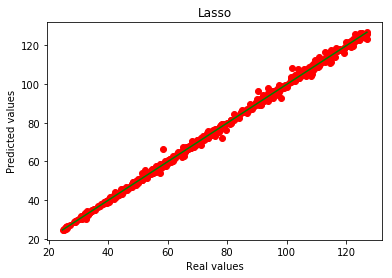


Ridge: 

score for training set: 0.998693180297
cross validation accuracy: 1.00 (+/- 0.00)
score for validation set: 0.998511552174
cross validation accuracy: 1.00 (+/- 0.00)


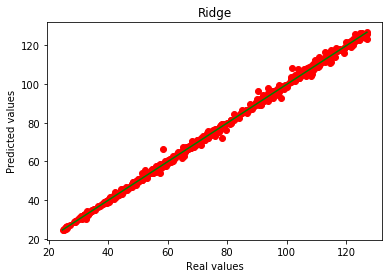


ElasticNet: 

score for training set: 0.998571543989
cross validation accuracy: 1.00 (+/- 0.00)
score for validation set: 0.998346897533
cross validation accuracy: 1.00 (+/- 0.00)


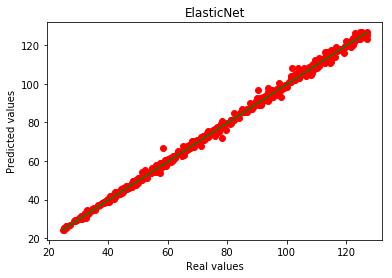


LinearRegression: 

score for training set: 0.99869786253
cross validation accuracy: 1.00 (+/- 0.00)
score for validation set: 0.998528337659
cross validation accuracy: 1.00 (+/- 0.00)


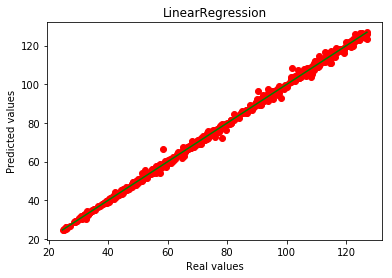

In [7]:
su.make_sure_path_exists('models')

for reg in estimators:
    class_name = reg.named_steps['reg'].__class__.__name__

    print ('\n{0}: \n'.format(class_name))

    reg.fit(X_train, y_train)

    print('score for training set: {0}'.format(reg.score(X_train, y_train)))

    su.print_cross_val_accuracy(reg, X_train, y_train)

    y_hat_valid = reg.predict(X_valid)
    print('score for validation set: {0}'.format(reg.score(X_valid, y_valid)))

    su.print_cross_val_accuracy(reg, X_valid, y_valid)

    su.plot_predictions(class_name, y_valid, y_hat_valid)

    filename = 'models/{0}.pkl'.format(class_name)

    joblib.dump(reg, filename) 

## Generate a test set and measure the prediction accuracy

In [8]:
symbol = tickers[0]
window = 5
look_ahead = 1
test_start_date = datetime.datetime(2017, 1, 1)
test_end_date = datetime.datetime(2017, 8, 31)

test_dataset = su.preprocess_data(symbol, window, look_ahead, test_start_date, test_end_date)

test_dataset.head()

,Adj. Open,Adj. High,Adj. Low,Adj. Close,Daily return,Rolling mean 5,Lower Bollinger band 5,Upper Bollinger band 5,Cummulative return 5,Future Price
2017-01-06,115.337596,116.700551,115.031425,116.453639,0.011148,115.128215,113.581518,116.674912,0.015153,116.453639
2017-01-07,115.337596,116.700551,115.031425,116.453639,0.000000,115.475867,113.638947,117.312787,0.015153,116.453639
2017-01-08,115.337596,116.700551,115.031425,116.453639,0.000000,115.823519,114.049355,117.597684,0.015153,117.520300
2017-01-09,116.493145,117.954865,116.483269,117.520300,0.009160,116.410183,114.743800,118.076566,0.025599,117.638817
2017-01-10,117.303017,117.905483,116.838822,117.638817,0.001008,116.904007,115.667780,118.140234,0.021439,118.270913



Lasso: 

score for validation set: 0.985185761643


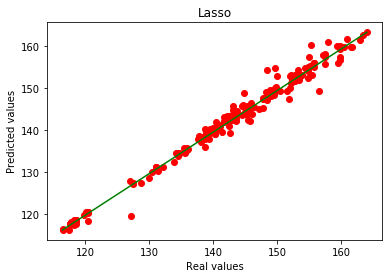


Ridge: 

score for validation set: 0.985160965763


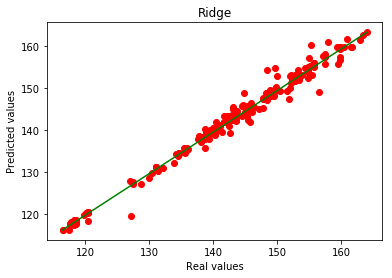


ElasticNet: 

score for validation set: 0.982847149327


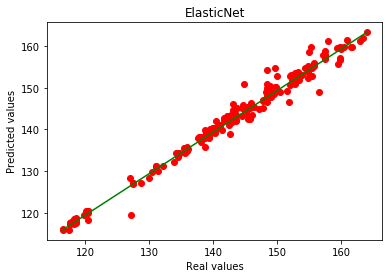


LinearRegression: 

score for validation set: 0.985197506525


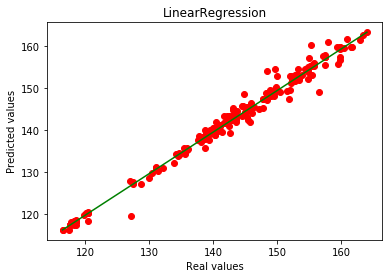


r2 score for average predictions: 0.984815292507

mean squared error for average predictions: 1.99798446349


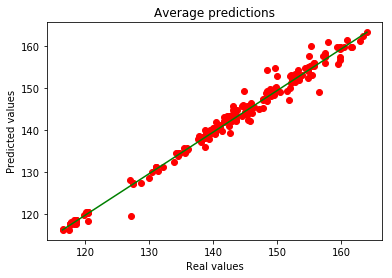

In [9]:
pred = su.calculate_predictions_for_dataset(dataset=test_dataset, estimators=estimators, plot_and_print=True)